# Using global and local regression to explore residential burglaries in the borough of Redbridge, London.

In [136]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm      
from scipy import stats      
from sklearn import linear_model  
from sklearn import model_selection
from libpysal import weights
from libpysal import cg as geometry
from shapely.geometry import Polygon
from shapely.wkt import loads  

import matplotlib.pyplot as plt
import matplotlib as mpl
import palettable.colorbrewer.sequential as pcs 
import seaborn as sns
import os
import urllib
import zipfile
import re
import pysal as ps
from pysal.model.spreg import OLS
from pysal.model.spreg import ML_Error
from pysal.model.spreg import ML_Lag
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import geopandas as gpd
import pandas as pd
import os
import urllib
import zipfile
import re
from descartes import PolygonPatch
from pysal.model import mgwr
import pysal.lib
import libpysal as ps
from libpysal.weights.contiguity import Queen
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
# conda install mgwr
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
import warnings
warnings.filterwarnings("ignore")

Data wrangling
- get crime data and check distribution - transform if not normal
- merge with lsoa data to get geometry for redbridge
- then merge with iv's

In [137]:
crime = pd.read_csv('/Users/aishahzahoor/Downloads/applications-sds/group_pres/report/LSOA burglary data.csv')
crime.head()

,LSOA Code,LSOA Name,avg
0,E01003638,Redbridge 017A,0.833333
1,E01003639,Redbridge 013A,0.583333
2,E01003640,Redbridge 013B,0.583333
3,E01003641,Redbridge 013C,0.416667
4,E01003642,Redbridge 013D,0.666667


array([[<AxesSubplot:title={'center':'avg'}>]], dtype=object)

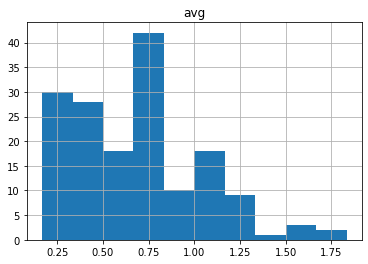

In [4]:
crime.hist()

In [139]:
crime.count()

LSOA Code    161
LSOA Name    161
avg          161
dtype: int64

In [140]:
crime

,LSOA Code,LSOA Name,avg
0,E01003638,Redbridge 017A,0.833333
1,E01003639,Redbridge 013A,0.583333
2,E01003640,Redbridge 013B,0.583333
3,E01003641,Redbridge 013C,0.416667
4,E01003642,Redbridge 013D,0.666667
...,...,...,...
156,E01032581,Redbridge 034G,0.583333
157,E01033589,Redbridge 030H,0.750000
158,E01033590,Redbridge 019H,0.166667
159,E01033591,Redbridge 030I,1.000000


In [141]:
crime['logavg'] = np.log(crime['avg'])

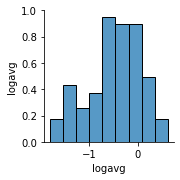

In [142]:
sns.pairplot(crime.iloc[:, 3:4])

In [143]:
crime['sqrtavg'] = np.sqrt(crime['avg'])

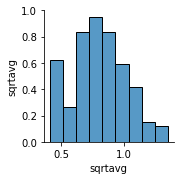

In [144]:
sns.pairplot(crime.iloc[:, 4:5])

In [145]:
lsoa = gpd.read_file('lsoas')

<AxesSubplot:>

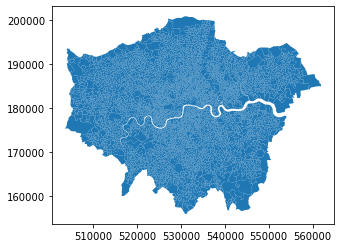

In [146]:
lsoa.plot()

In [147]:
lsoa

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,0,112.9,876,1.7,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,0,62.9,830,1.7,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,96,227.7,817,1.5,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,0,52.0,467,2.1,"POLYGON ((533807.946 180767.770, 533649.063 18..."
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,4,116.2,543,3.1,"POLYGON ((545122.049 184314.931, 545271.917 18..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,E01033742,Greenwich 007F,E02000319,Greenwich 007,E09000011,Greenwich,E12000007,London,1352,1352,0,107.6,581,2.3,"POLYGON ((544642.680 179824.674, 544766.313 17..."
4831,E01033743,Greenwich 002H,E02000314,Greenwich 002,E09000011,Greenwich,E12000007,London,2038,2038,0,20.4,663,3.1,"POLYGON ((546579.195 181097.813, 546687.036 18..."
4832,E01033744,Greenwich 007G,E02000319,Greenwich 007,E09000011,Greenwich,E12000007,London,1845,1728,117,125.8,646,2.7,"POLYGON ((544536.486 179447.115, 544602.630 17..."
4833,E01033745,Greenwich 002I,E02000314,Greenwich 002,E09000011,Greenwich,E12000007,London,1820,1820,0,32.3,591,3.1,"POLYGON ((546415.745 180152.270, 546320.715 18..."


In [148]:
redbridge = lsoa[lsoa.LAD11NM.str.contains('Redbridge')]

<AxesSubplot:>

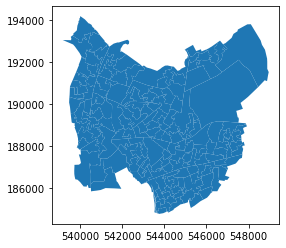

In [149]:
redbridge.plot()

In [150]:
redbridge

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
3556,E01003638,Redbridge 017A,E02000767,Redbridge 017,E09000026,Redbridge,E12000007,London,1611,1611,0,60.2,590,2.7,"POLYGON ((544454.071 189736.573, 544586.013 18..."
3557,E01003639,Redbridge 013A,E02000763,Redbridge 013,E09000026,Redbridge,E12000007,London,1758,1758,0,16.9,665,2.6,"POLYGON ((545352.302 189726.221, 545428.815 18..."
3558,E01003640,Redbridge 013B,E02000763,Redbridge 013,E09000026,Redbridge,E12000007,London,1771,1771,0,2.9,648,2.7,"POLYGON ((547533.084 189227.054, 547515.102 18..."
3559,E01003641,Redbridge 013C,E02000763,Redbridge 013,E09000026,Redbridge,E12000007,London,1704,1692,12,64.3,530,3.2,"POLYGON ((545687.000 189215.000, 545665.999 18..."
3560,E01003642,Redbridge 013D,E02000763,Redbridge 013,E09000026,Redbridge,E12000007,London,1695,1689,6,55.6,542,3.1,"POLYGON ((545353.072 188993.282, 545435.546 18..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4661,E01032581,Redbridge 034G,E02006800,Redbridge 034,E09000026,Redbridge,E12000007,London,1652,1652,0,57.1,699,2.4,"POLYGON ((547566.688 187393.297, 547426.888 18..."
4776,E01033589,Redbridge 030H,E02000780,Redbridge 030,E09000026,Redbridge,E12000007,London,1676,1676,0,137.5,660,2.5,"POLYGON ((544562.757 186870.773, 544601.979 18..."
4777,E01033590,Redbridge 019H,E02000769,Redbridge 019,E09000026,Redbridge,E12000007,London,1111,1098,13,113.7,434,2.5,"POLYGON ((547086.001 188662.000, 547105.945 18..."
4778,E01033591,Redbridge 030I,E02000780,Redbridge 030,E09000026,Redbridge,E12000007,London,1908,1898,10,75.0,630,3.0,"POLYGON ((545095.438 187022.359, 545049.521 18..."


In [151]:
redbridge.reset_index(level=0, inplace=True)

In [152]:
redbridge.head()

,index,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,3556,E01003638,Redbridge 017A,E02000767,Redbridge 017,E09000026,Redbridge,E12000007,London,1611,1611,0,60.2,590,2.7,"POLYGON ((544454.071 189736.573, 544586.013 18..."
1,3557,E01003639,Redbridge 013A,E02000763,Redbridge 013,E09000026,Redbridge,E12000007,London,1758,1758,0,16.9,665,2.6,"POLYGON ((545352.302 189726.221, 545428.815 18..."
2,3558,E01003640,Redbridge 013B,E02000763,Redbridge 013,E09000026,Redbridge,E12000007,London,1771,1771,0,2.9,648,2.7,"POLYGON ((547533.084 189227.054, 547515.102 18..."
3,3559,E01003641,Redbridge 013C,E02000763,Redbridge 013,E09000026,Redbridge,E12000007,London,1704,1692,12,64.3,530,3.2,"POLYGON ((545687.000 189215.000, 545665.999 18..."
4,3560,E01003642,Redbridge 013D,E02000763,Redbridge 013,E09000026,Redbridge,E12000007,London,1695,1689,6,55.6,542,3.1,"POLYGON ((545353.072 188993.282, 545435.546 18..."


In [153]:
df = crime.rename(columns={'LSOA Name': 'LSOA11NM'})

In [154]:
df

,LSOA Code,LSOA11NM,avg,logavg,sqrtavg
0,E01003638,Redbridge 017A,0.833333,-0.182322,0.912871
1,E01003639,Redbridge 013A,0.583333,-0.538997,0.763763
2,E01003640,Redbridge 013B,0.583333,-0.538997,0.763763
3,E01003641,Redbridge 013C,0.416667,-0.875469,0.645497
4,E01003642,Redbridge 013D,0.666667,-0.405465,0.816497
...,...,...,...,...,...
156,E01032581,Redbridge 034G,0.583333,-0.538997,0.763763
157,E01033589,Redbridge 030H,0.750000,-0.287682,0.866025
158,E01033590,Redbridge 019H,0.166667,-1.791759,0.408248
159,E01033591,Redbridge 030I,1.000000,0.000000,1.000000


In [155]:
data = df.merge(redbridge, on='LSOA11NM', how='left')

In [156]:
data

,LSOA Code,LSOA11NM,avg,logavg,sqrtavg,index,LSOA11CD,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E01003638,Redbridge 017A,0.833333,-0.182322,0.912871,3556,E01003638,E02000767,Redbridge 017,E09000026,Redbridge,E12000007,London,1611,1611,0,60.2,590,2.7,"POLYGON ((544454.071 189736.573, 544586.013 18..."
1,E01003639,Redbridge 013A,0.583333,-0.538997,0.763763,3557,E01003639,E02000763,Redbridge 013,E09000026,Redbridge,E12000007,London,1758,1758,0,16.9,665,2.6,"POLYGON ((545352.302 189726.221, 545428.815 18..."
2,E01003640,Redbridge 013B,0.583333,-0.538997,0.763763,3558,E01003640,E02000763,Redbridge 013,E09000026,Redbridge,E12000007,London,1771,1771,0,2.9,648,2.7,"POLYGON ((547533.084 189227.054, 547515.102 18..."
3,E01003641,Redbridge 013C,0.416667,-0.875469,0.645497,3559,E01003641,E02000763,Redbridge 013,E09000026,Redbridge,E12000007,London,1704,1692,12,64.3,530,3.2,"POLYGON ((545687.000 189215.000, 545665.999 18..."
4,E01003642,Redbridge 013D,0.666667,-0.405465,0.816497,3560,E01003642,E02000763,Redbridge 013,E09000026,Redbridge,E12000007,London,1695,1689,6,55.6,542,3.1,"POLYGON ((545353.072 188993.282, 545435.546 18..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,E01032581,Redbridge 034G,0.583333,-0.538997,0.763763,4661,E01032581,E02006800,Redbridge 034,E09000026,Redbridge,E12000007,London,1652,1652,0,57.1,699,2.4,"POLYGON ((547566.688 187393.297, 547426.888 18..."
157,E01033589,Redbridge 030H,0.750000,-0.287682,0.866025,4776,E01033589,E02000780,Redbridge 030,E09000026,Redbridge,E12000007,London,1676,1676,0,137.5,660,2.5,"POLYGON ((544562.757 186870.773, 544601.979 18..."
158,E01033590,Redbridge 019H,0.166667,-1.791759,0.408248,4777,E01033590,E02000769,Redbridge 019,E09000026,Redbridge,E12000007,London,1111,1098,13,113.7,434,2.5,"POLYGON ((547086.001 188662.000, 547105.945 18..."
159,E01033591,Redbridge 030I,1.000000,0.000000,1.000000,4778,E01033591,E02000780,Redbridge 030,E09000026,Redbridge,E12000007,London,1908,1898,10,75.0,630,3.0,"POLYGON ((545095.438 187022.359, 545049.521 18..."


In [157]:
type(data)

pandas.core.frame.DataFrame

In [158]:
gdf= gpd.GeoDataFrame(data)

In [159]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

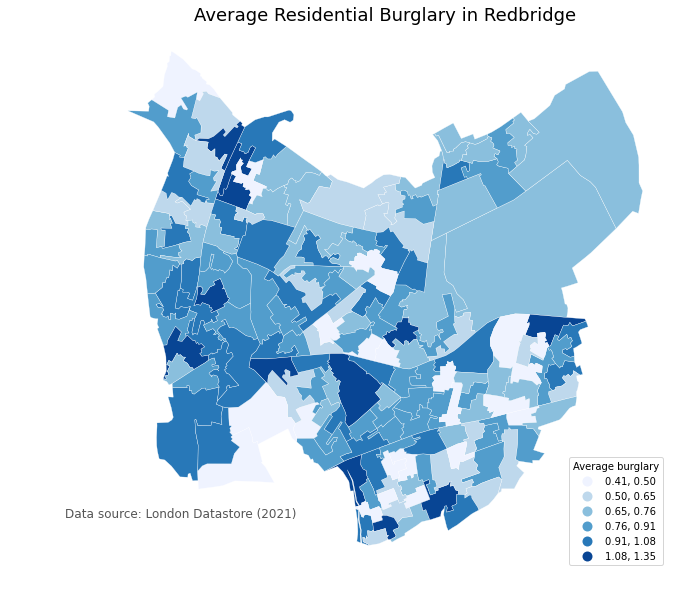

In [160]:
fig, ax1 = plt.subplots(1, figsize=(12,10))
gdf.plot(ax=ax1, 
         column= 'sqrtavg', scheme= 'fisher_jenks',
         k=6,
        cmap = pcs.Blues_7.mpl_colormap,
        edgecolor='white', linewidth=0.3,
        legend=True,legend_kwds={"title":'Average burglary',"loc": 'lower right'})

ax1.axis('off')
ax1.set_title("Average Residential Burglary in Redbridge", fontsize=18)
ax1.annotate('Data source: London Datastore (2021)',
            xy=(0.075,0.12), xycoords='figure fraction', 
             horizontalalignment='left', verticalalignment='top', 
             fontsize=12, color='#555555')
fig.savefig('Residential_burglary.png', dpi=300, bbox_inches='tight') 
plt.show()

In [161]:
iv = pd.read_csv('/Users/aishahzahoor/Downloads/applications-sds/group_pres/redbridgeiv.csv')

In [162]:
iv

,LSOA11CD,LSOA11NM,LAD11CD,LAD11NM,IMD,Income,Employment,Education,Crime,BHS,LivingEnv,MedianIncome,AVHHOLDSZ,RoadsArea,HP,POPDEN
0,E01003638,Redbridge 017A,E09000026,Redbridge,17.7,0.1,0.1,12.1,0.0,29.1,18.6,36190.0,2.7,186329.713800,437781.0,60.2
1,E01003639,Redbridge 013A,E09000026,Redbridge,20.3,0.1,0.1,12.8,0.4,34.1,20.9,35120.0,2.6,3174.045566,332547.0,16.9
2,E01003640,Redbridge 013B,E09000026,Redbridge,17.8,0.1,0.1,11.5,0.8,32.5,29.4,37460.0,2.7,408729.380300,355894.0,2.9
3,E01003641,Redbridge 013C,E09000026,Redbridge,14.3,0.1,0.1,9.4,0.1,23.9,23.1,37680.0,3.2,0.000000,408518.0,64.3
4,E01003642,Redbridge 013D,E09000026,Redbridge,16.5,0.1,0.1,10.5,0.1,27.9,20.7,35530.0,3.1,0.000000,314244.0,55.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1043897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1043898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1043899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [163]:
full_data = gdf.merge(iv, on='LSOA11NM', how='left')

In [164]:
full_data.head()

,LSOA Code,LSOA11NM,avg,logavg,sqrtavg,index,LSOA11CD_x,MSOA11CD,MSOA11NM,LAD11CD_x,...,Employment,Education,Crime,BHS,LivingEnv,MedianIncome,AVHHOLDSZ_y,RoadsArea,HP,POPDEN_y
0,E01003638,Redbridge 017A,0.833333,-0.182322,0.912871,3556,E01003638,E02000767,Redbridge 017,E09000026,...,0.1,12.1,0.0,29.1,18.6,36190.0,2.7,186329.713800,437781.0,60.2
1,E01003639,Redbridge 013A,0.583333,-0.538997,0.763763,3557,E01003639,E02000763,Redbridge 013,E09000026,...,0.1,12.8,0.4,34.1,20.9,35120.0,2.6,3174.045566,332547.0,16.9
2,E01003640,Redbridge 013B,0.583333,-0.538997,0.763763,3558,E01003640,E02000763,Redbridge 013,E09000026,...,0.1,11.5,0.8,32.5,29.4,37460.0,2.7,408729.380300,355894.0,2.9
3,E01003641,Redbridge 013C,0.416667,-0.875469,0.645497,3559,E01003641,E02000763,Redbridge 013,E09000026,...,0.1,9.4,0.1,23.9,23.1,37680.0,3.2,0.000000,408518.0,64.3
4,E01003642,Redbridge 013D,0.666667,-0.405465,0.816497,3560,E01003642,E02000763,Redbridge 013,E09000026,...,0.1,10.5,0.1,27.9,20.7,35530.0,3.1,0.000000,314244.0,55.6


In [165]:
full_data.columns

Index(['LSOA Code', 'LSOA11NM', 'avg', 'logavg', 'sqrtavg', 'index',
       'LSOA11CD_x', 'MSOA11CD', 'MSOA11NM', 'LAD11CD_x', 'LAD11NM_x',
       'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN_x',
       'HHOLDS', 'AVHHOLDSZ_x', 'geometry', 'LSOA11CD_y', 'LAD11CD_y',
       'LAD11NM_y', 'IMD', 'Income', 'Employment', 'Education', 'Crime', 'BHS',
       'LivingEnv', 'MedianIncome', 'AVHHOLDSZ_y', 'RoadsArea', 'HP',
       'POPDEN_y'],
      dtype='object')

In [166]:
full_data.count()

LSOA Code       161
LSOA11NM        161
avg             161
logavg          161
sqrtavg         161
index           161
LSOA11CD_x      161
MSOA11CD        161
MSOA11NM        161
LAD11CD_x       161
LAD11NM_x       161
RGN11CD         161
RGN11NM         161
USUALRES        161
HHOLDRES        161
COMESTRES       161
POPDEN_x        161
HHOLDS          161
AVHHOLDSZ_x     161
geometry        161
LSOA11CD_y      161
LAD11CD_y       161
LAD11NM_y       161
IMD             161
Income          161
Employment      161
Education       161
Crime           161
BHS             161
LivingEnv       161
MedianIncome    161
AVHHOLDSZ_y     161
RoadsArea       161
HP              161
POPDEN_y        161
dtype: int64

Pairplots to check the distribution and what needs transforming

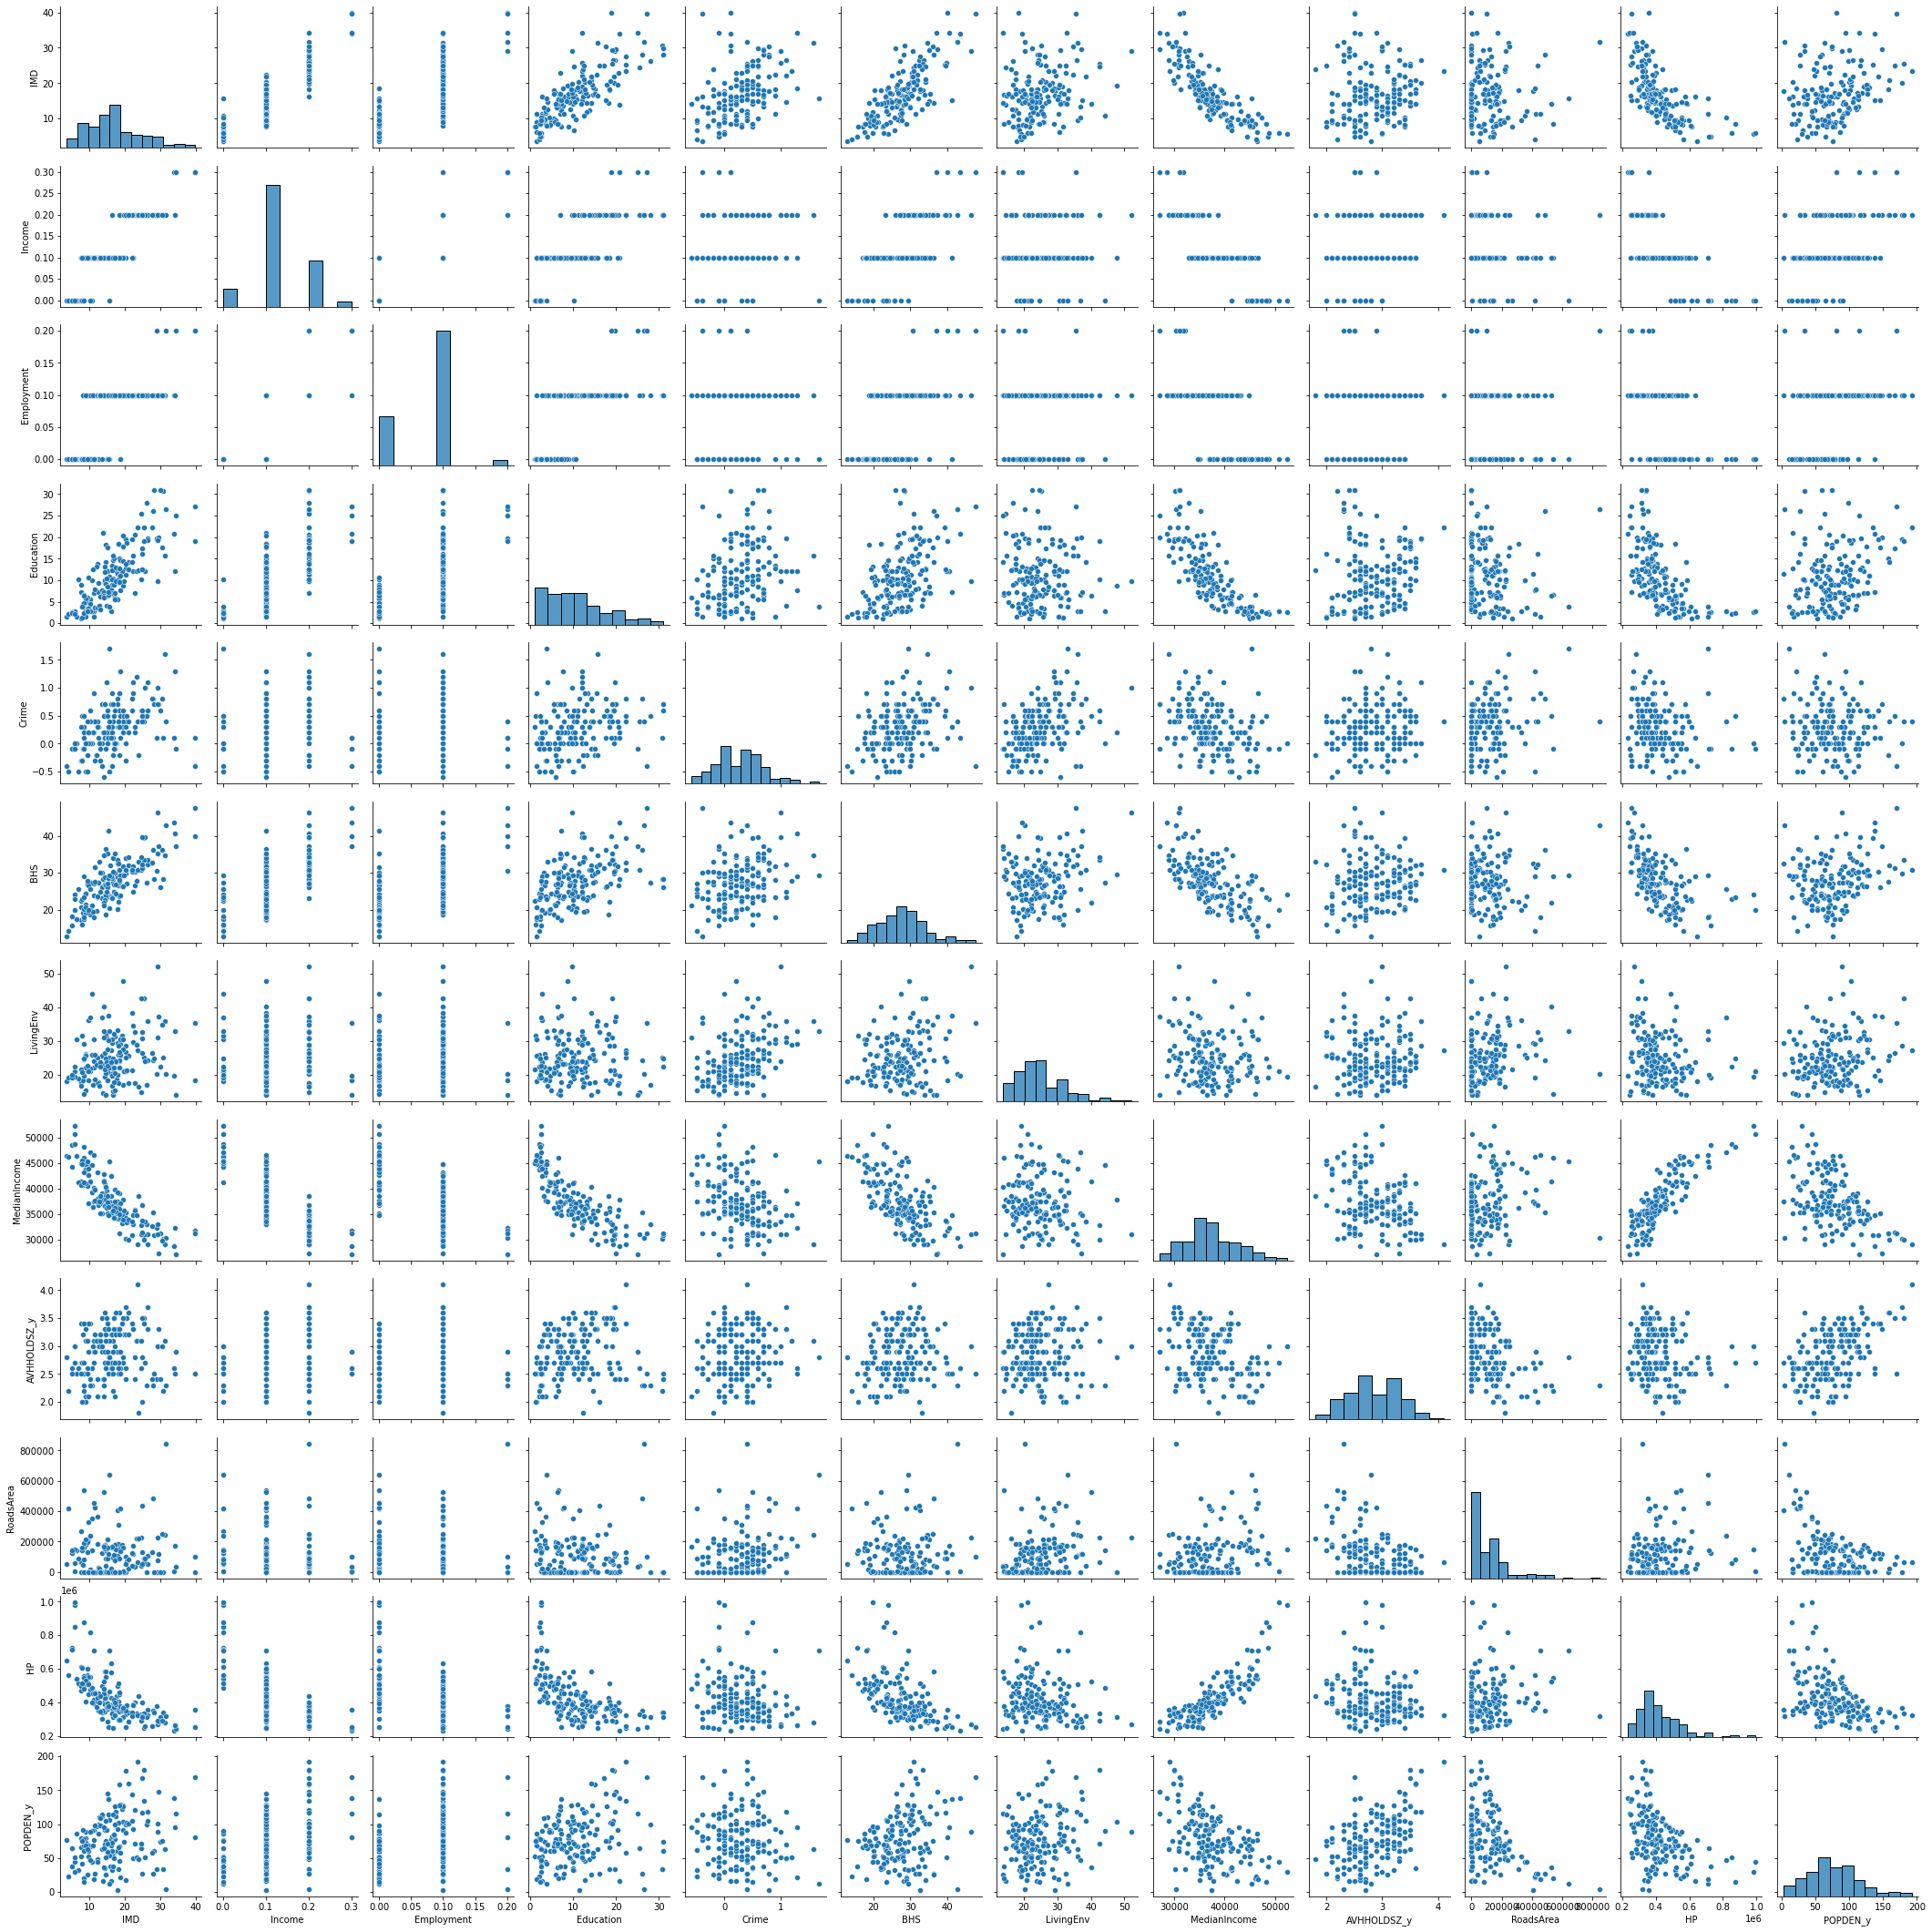

In [167]:
sns.pairplot(full_data.iloc[:, 23:35])

In [168]:
full_data['logIMD'] = np.log(full_data['IMD'])

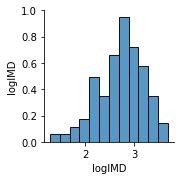

In [169]:
sns.pairplot(full_data.iloc[:, 35:36])

In [170]:
full_data['logIMD'] = np.log(full_data['IMD'])
df_X = full_data['logIMD']
df_y = full_data['sqrtavg']                  

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

#fit the model 
mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

mod_dlc

LinearRegression()

In [171]:
print(mod_dlc.intercept_)
print(mod_dlc.coef_)

0.8893244987926507
[-0.03086569]


In [172]:
mod_dlc = sm.OLS.from_formula("sqrtavg ~ logIMD", data = full_data) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())

                            OLS Regression Results                            
Dep. Variable:                sqrtavg   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7817
Date:                Wed, 12 Jan 2022   Prob (F-statistic):              0.378
Time:                        22:54:04   Log-Likelihood:                 27.602
No. Observations:                 161   AIC:                            -51.20
Df Residuals:                     159   BIC:                            -45.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8893      0.097      9.205      0.0

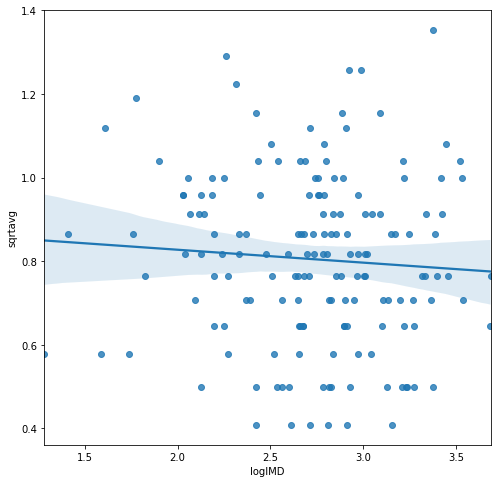

In [173]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.regplot(x=full_data.logIMD, y=full_data.sqrtavg) 

In [174]:
full_data['logIncome1'] = np.log(full_data['Income']+1)

In [175]:
full_data['logIncome1'] = np.log(full_data['Income']+1)
df_X = full_data['logIncome1']
df_y = full_data['sqrtavg']                  

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

#fit the model 
mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

mod_dlc

LinearRegression()

In [176]:
mod_dlc = sm.OLS.from_formula("sqrtavg ~ logIncome1", data = full_data) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())

                            OLS Regression Results                            
Dep. Variable:                sqrtavg   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.363
Date:                Wed, 12 Jan 2022   Prob (F-statistic):              0.245
Time:                        22:54:06   Log-Likelihood:                 27.894
No. Observations:                 161   AIC:                            -51.79
Df Residuals:                     159   BIC:                            -45.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8428      0.036     23.327      0.0

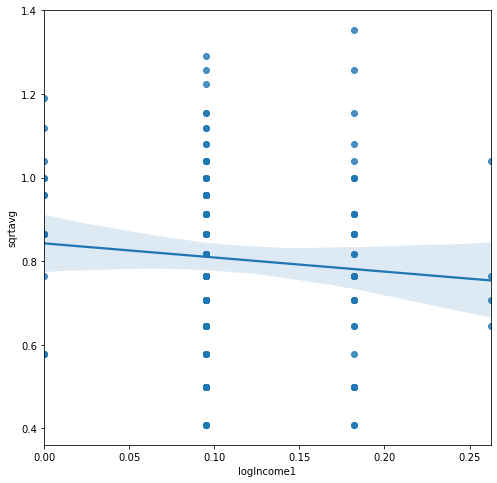

In [177]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.regplot(x=full_data.logIncome1, y=full_data.sqrtavg) 

In [178]:
full_data['logEmployment1'] = np.log(full_data['Employment']+1)

In [179]:
df_X = full_data['logEmployment1']
df_y = full_data['sqrtavg']                  

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

#fit the model 
mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

mod_dlc

LinearRegression()

In [180]:
print(mod_dlc.intercept_)
print(mod_dlc.coef_)

0.865902285193223
[-0.83109373]


In [181]:
mod_dlc = sm.OLS.from_formula("sqrtavg ~ logEmployment1", data = full_data) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())

                            OLS Regression Results                            
Dep. Variable:                sqrtavg   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     5.761
Date:                Wed, 12 Jan 2022   Prob (F-statistic):             0.0175
Time:                        22:54:10   Log-Likelihood:                 30.072
No. Observations:                 161   AIC:                            -56.14
Df Residuals:                     159   BIC:                            -49.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.8659      0.030     28.

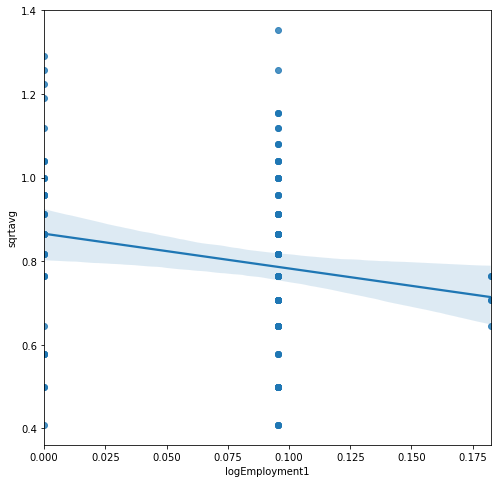

In [182]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.regplot(x=full_data.logEmployment1, y=full_data.sqrtavg) 

In [183]:
full_data['sqrtEducation'] = np.sqrt(full_data['Education'])

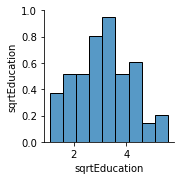

In [184]:
sns.pairplot(full_data.iloc[:, 38:39])

In [185]:
df_X = full_data['sqrtEducation']
df_y = full_data['sqrtavg']                  

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

#fit the model 
mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

mod_dlc

LinearRegression()

In [186]:
print(mod_dlc.intercept_)
print(mod_dlc.coef_)

0.9136758234136056
[-0.03460317]


In [187]:
mod_dlc = sm.OLS.from_formula("sqrtavg ~ sqrtEducation", data = full_data) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())

                            OLS Regression Results                            
Dep. Variable:                sqrtavg   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     5.228
Date:                Wed, 12 Jan 2022   Prob (F-statistic):             0.0235
Time:                        22:54:12   Log-Likelihood:                 29.811
No. Observations:                 161   AIC:                            -55.62
Df Residuals:                     159   BIC:                            -49.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.9137      0.050     18.241

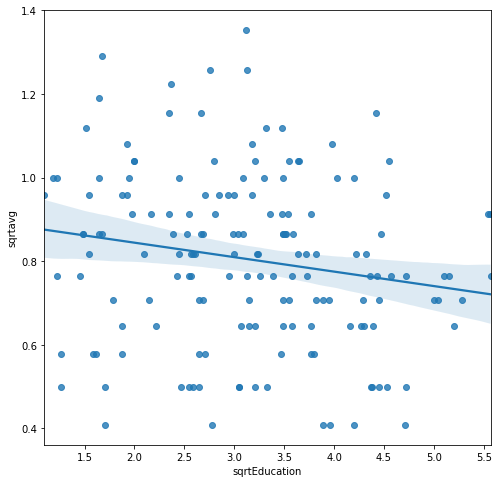

In [188]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.regplot(x=full_data.sqrtEducation, y=full_data.sqrtavg) 

In [189]:
df_X = full_data['BHS']
df_y = full_data['sqrtavg']                  

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

#fit the model 
mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

mod_dlc

LinearRegression()

In [190]:
print(mod_dlc.intercept_)
print(mod_dlc.coef_)

0.847849711884853
[-0.00154894]


In [191]:
mod_dlc = sm.OLS.from_formula("sqrtavg ~ BHS", data = full_data) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())

                            OLS Regression Results                            
Dep. Variable:                sqrtavg   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.3647
Date:                Wed, 12 Jan 2022   Prob (F-statistic):              0.547
Time:                        22:54:14   Log-Likelihood:                 27.391
No. Observations:                 161   AIC:                            -50.78
Df Residuals:                     159   BIC:                            -44.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8478      0.073     11.679      0.0

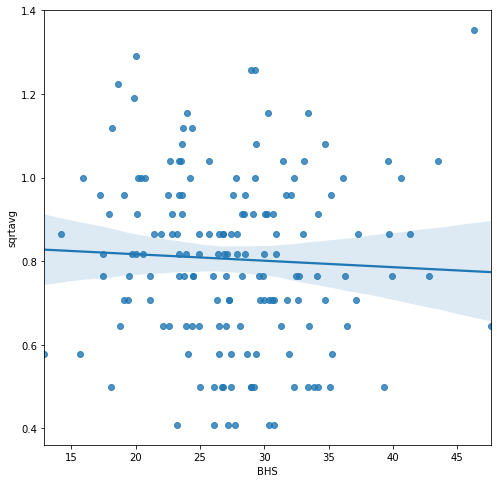

In [192]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.regplot(x=full_data.BHS, y=full_data.sqrtavg) 

In [193]:
full_data['logLivingEnv'] = np.log(full_data['LivingEnv'])
df_X = full_data['logLivingEnv']
df_y = full_data['sqrtavg']                  

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

#fit the model 
mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

mod_dlc

LinearRegression()

In [194]:
print(mod_dlc.intercept_)
print(mod_dlc.coef_)

0.4150693933900963
[0.12257722]


In [195]:
mod_dlc = sm.OLS.from_formula("sqrtavg ~ logLivingEnv", data = full_data) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())

                            OLS Regression Results                            
Dep. Variable:                sqrtavg   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     4.232
Date:                Wed, 12 Jan 2022   Prob (F-statistic):             0.0413
Time:                        22:54:18   Log-Likelihood:                 29.321
No. Observations:                 161   AIC:                            -54.64
Df Residuals:                     159   BIC:                            -48.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.4151      0.190      2.181   

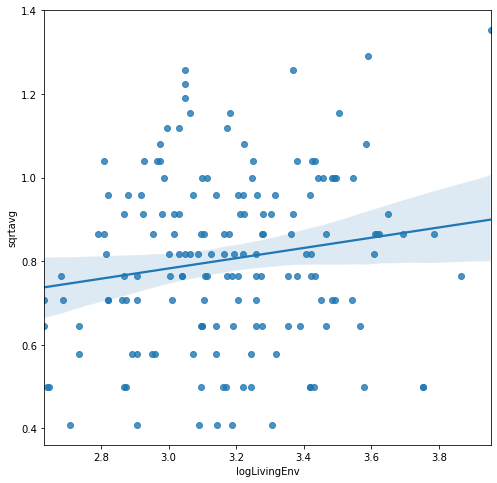

In [196]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.regplot(x=full_data.logLivingEnv, y=full_data.sqrtavg) 

In [197]:
full_data['logMedianIncome'] = np.log(full_data['MedianIncome'])
df_X = full_data['logMedianIncome']
df_y = full_data['sqrtavg']                  

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

#fit the model 
mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

mod_dlc

LinearRegression()

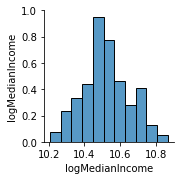

In [198]:
sns.pairplot(full_data.iloc[:, 40:41])

In [199]:
print(mod_dlc.intercept_)
print(mod_dlc.coef_)

-1.243798947883606
[0.19476078]


In [200]:
mod_dlc = sm.OLS.from_formula("sqrtavg ~ logMedianIncome", data = full_data) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())

                            OLS Regression Results                            
Dep. Variable:                sqrtavg   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.587
Date:                Wed, 12 Jan 2022   Prob (F-statistic):              0.110
Time:                        22:54:20   Log-Likelihood:                 28.506
No. Observations:                 161   AIC:                            -53.01
Df Residuals:                     159   BIC:                            -46.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.2438      1.274     

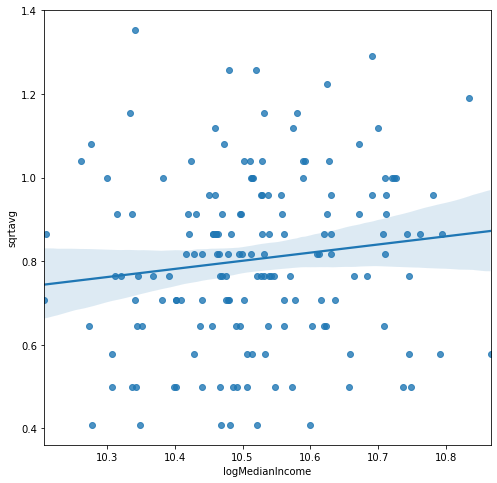

In [201]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.regplot(x=full_data.logMedianIncome, y=full_data.sqrtavg) 

In [202]:
full_data['logAVHHOLDSZ_y'] = np.log(full_data['AVHHOLDSZ_y'])
df_X = full_data['logAVHHOLDSZ_y']
df_y = full_data['sqrtavg']                  

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

#fit the model 
mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

mod_dlc

LinearRegression()

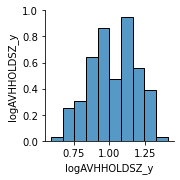

In [203]:
sns.pairplot(full_data.iloc[:, 41:42])

In [204]:
print(mod_dlc.intercept_)
print(mod_dlc.coef_)

1.13248085196447
[-0.31591023]


In [205]:
mod_dlc = sm.OLS.from_formula("sqrtavg ~ logAVHHOLDSZ_y", data = full_data) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())

                            OLS Regression Results                            
Dep. Variable:                sqrtavg   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     10.05
Date:                Wed, 12 Jan 2022   Prob (F-statistic):            0.00183
Time:                        22:54:23   Log-Likelihood:                 32.140
No. Observations:                 161   AIC:                            -60.28
Df Residuals:                     159   BIC:                            -54.12
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.1325      0.104     10.

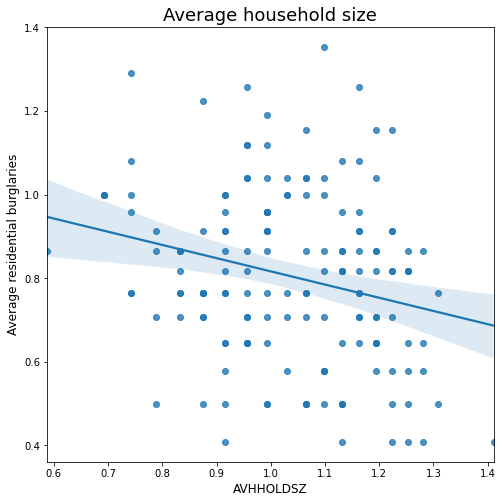

In [230]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.regplot(x=full_data.logAVHHOLDSZ_y, y=full_data.sqrtavg) 
ax.set_title("Average household size", fontsize=18)
plt.xlabel("AVHHOLDSZ", fontsize=12)
plt.ylabel("Average residential burglaries", fontsize=12)
fig.savefig('avhholdsz.png', dpi=300, bbox_inches='tight') 

In [207]:
full_data['logRoadsArea1'] = np.log(full_data['RoadsArea']+1)
df_X = full_data['logRoadsArea1']
df_y = full_data['sqrtavg']                  

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

#fit the model 
mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

mod_dlc

LinearRegression()

In [208]:
print(mod_dlc.intercept_)
print(mod_dlc.coef_)

0.7898852894590884
[0.00186893]


In [209]:
mod_dlc = sm.OLS.from_formula("sqrtavg ~ logRoadsArea1", data = full_data) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())

                            OLS Regression Results                            
Dep. Variable:                sqrtavg   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.3801
Date:                Wed, 12 Jan 2022   Prob (F-statistic):              0.538
Time:                        22:54:25   Log-Likelihood:                 27.399
No. Observations:                 161   AIC:                            -50.80
Df Residuals:                     159   BIC:                            -44.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7899      0.030     26.752

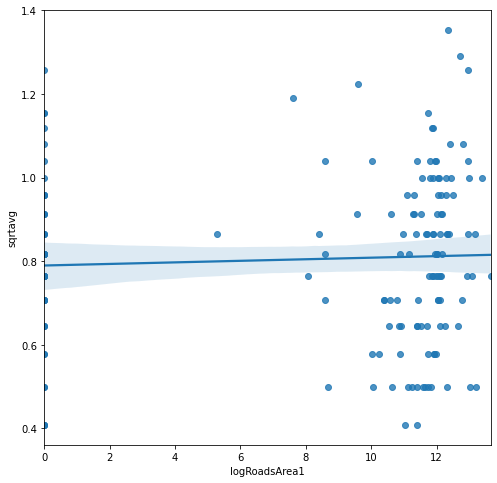

In [210]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.regplot(x=full_data.logRoadsArea1, y=full_data.sqrtavg) 

In [211]:
full_data['logHP'] = np.log(full_data['HP'])
df_X = full_data['logHP']
df_y = full_data['sqrtavg']                  

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

#fit the model 
mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

mod_dlc

LinearRegression()

In [212]:
print(mod_dlc.intercept_)
print(mod_dlc.coef_)

0.059401691202029094
[0.05773257]


In [213]:
mod_dlc = sm.OLS.from_formula("sqrtavg ~ logHP", data = full_data) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())

                            OLS Regression Results                            
Dep. Variable:                sqrtavg   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.015
Date:                Wed, 12 Jan 2022   Prob (F-statistic):              0.315
Time:                        22:54:27   Log-Likelihood:                 27.719
No. Observations:                 161   AIC:                            -51.44
Df Residuals:                     159   BIC:                            -45.28
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0594      0.740      0.080      0.9

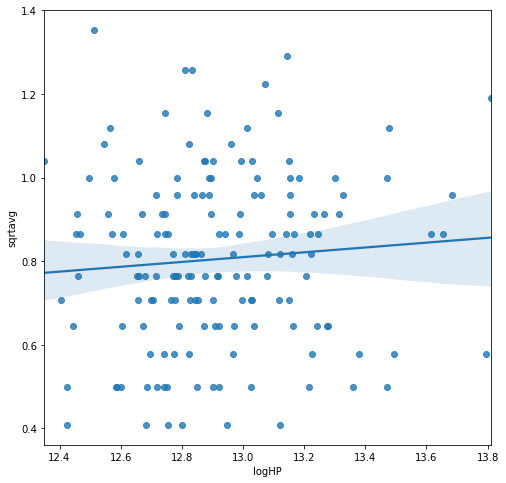

In [214]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.regplot(x=full_data.logHP, y=full_data.sqrtavg) 

In [215]:
df_X = full_data['POPDEN_y']
df_y = full_data['sqrtavg']                  

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

#fit the model 
mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

mod_dlc

LinearRegression()

In [216]:
mod_dlc = sm.OLS.from_formula("sqrtavg ~ POPDEN_y", data = full_data) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())

                            OLS Regression Results                            
Dep. Variable:                sqrtavg   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     8.442
Date:                Wed, 12 Jan 2022   Prob (F-statistic):            0.00419
Time:                        22:54:29   Log-Likelihood:                 31.371
No. Observations:                 161   AIC:                            -58.74
Df Residuals:                     159   BIC:                            -52.58
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8993      0.036     24.946      0.0

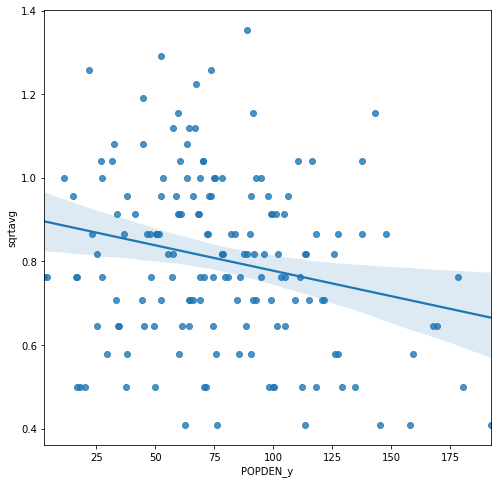

In [217]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.regplot(x=full_data.POPDEN_y, y=full_data.sqrtavg) 

select variables with the highest r^2 and lowest AIC:
- employment
- education
- AVHHOLDSZ
- POPDEN

then OLS

In [218]:
mod_dlc_RR_pred  = mod_dlc_RR.predict()

In [219]:
stats.kendalltau(full_data['sqrtavg'], mod_dlc_RR_pred)

KendalltauResult(correlation=0.13408561826021828, pvalue=0.014582010934746903)

In [220]:
full_data.columns

Index(['LSOA Code', 'LSOA11NM', 'avg', 'logavg', 'sqrtavg', 'index',
       'LSOA11CD_x', 'MSOA11CD', 'MSOA11NM', 'LAD11CD_x', 'LAD11NM_x',
       'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN_x',
       'HHOLDS', 'AVHHOLDSZ_x', 'geometry', 'LSOA11CD_y', 'LAD11CD_y',
       'LAD11NM_y', 'IMD', 'Income', 'Employment', 'Education', 'Crime', 'BHS',
       'LivingEnv', 'MedianIncome', 'AVHHOLDSZ_y', 'RoadsArea', 'HP',
       'POPDEN_y', 'logIMD', 'logIncome1', 'logEmployment1', 'sqrtEducation',
       'logLivingEnv', 'logMedianIncome', 'logAVHHOLDSZ_y', 'logRoadsArea1',
       'logHP'],
      dtype='object')

In [221]:
df_X = full_data[['logEmployment1','sqrtEducation', 'logAVHHOLDSZ_y', 'POPDEN_y']]  
df_y = full_data['sqrtavg']                  

#fit the mode 
mod_dlc_dbh = linear_model.LinearRegression()
mod_dlc_dbh.fit(df_X, df_y)

#we can get simple otuputs
print(mod_dlc_dbh.coef_)  #model coefficients
print(mod_dlc_dbh.score(df_X, df_y)) #r2

[-0.43386143 -0.01178981 -0.22625853 -0.00054599]
0.09430329949139737


In [222]:
average = full_data['sqrtavg']
# Read in the average burglary rate (dependent variable) into an array y
y = np.array(average)
# PySAL requires your dependent variable to be nx1 numpy array
y.shape = (len(average),1)

# value for independent variables into a one dimmensional array X. 
# You can feel free to change the independant variables
X= []
X.append(full_data['logEmployment1']) # Deprivation index in 2019
X.append(full_data['sqrtEducation']) # Deprivation index in 2019
X.append(full_data['logAVHHOLDSZ_y']) # LSOA data 2011
X.append(full_data['POPDEN_y']) # LSOA data 2011
 # number of airbnbs
X = np.array(X).T

In [223]:
print(X.shape)

(161, 4)


In [224]:
m1 = OLS(y, X, name_y='sqrtavg',
         name_x=['logEmployment1','sqrtEducation','logAVHHOLDSZ_y','POPDEN_y'], 
         name_ds='full_data')
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :   full_data
Weights matrix      :        None
Dependent Variable  :     sqrtavg                Number of Observations:         161
Mean dependent var  :      0.8051                Number of Variables   :           5
S.D. dependent var  :      0.2050                Degrees of Freedom    :         156
R-squared           :      0.0943
Adjusted R-squared  :      0.0711
Sum squared residual:       6.089                F-statistic           :      4.0608
Sigma-square        :       0.039                Prob(F-statistic)     :    0.003687
S.E. of regression  :       0.198                Log likelihood        :      35.181
Sigma-square ML     :       0.038                Akaike info criterion :     -60.361
S.E of regression ML:      0.1945                Schwarz criterion     :     -44.954

-----------------------------------------------------------------------------

In [96]:
full_data.head()

,LSOA Code,LSOA11NM,avg,logavg,sqrtavg,index,LSOA11CD_x,MSOA11CD,MSOA11NM,LAD11CD_x,...,POPDEN_y,logIMD,logIncome1,logEmployment1,sqrtEducation,logLivingEnv,logMedianIncome,logAVHHOLDSZ_y,logRoadsArea1,logHP
0,E01003638,Redbridge 017A,0.833333,-0.182322,0.912871,3556,E01003638,E02000767,Redbridge 017,E09000026,...,60.2,2.873565,0.09531,0.09531,3.478505,2.923162,10.496538,0.993252,12.135278,12.989474
1,E01003639,Redbridge 013A,0.583333,-0.538997,0.763763,3557,E01003639,E02000763,Redbridge 013,E09000026,...,16.9,3.010621,0.09531,0.09531,3.577709,3.039749,10.466526,0.955511,8.063077,12.714536
2,E01003640,Redbridge 013B,0.583333,-0.538997,0.763763,3558,E01003640,E02000763,Redbridge 013,E09000026,...,2.9,2.879198,0.09531,0.09531,3.391165,3.380995,10.531029,0.993252,12.920811,12.782388
3,E01003641,Redbridge 013C,0.416667,-0.875469,0.645497,3559,E01003641,E02000763,Redbridge 013,E09000026,...,64.3,2.660260,0.09531,0.09531,3.065942,3.139833,10.536885,1.163151,0.000000,12.920291
4,E01003642,Redbridge 013D,0.666667,-0.405465,0.816497,3560,E01003642,E02000763,Redbridge 013,E09000026,...,55.6,2.803360,0.09531,0.09531,3.240370,3.030134,10.478133,1.131402,0.000000,12.657925


In [97]:
full_data.columns

Index(['LSOA Code', 'LSOA11NM', 'avg', 'logavg', 'sqrtavg', 'index',
       'LSOA11CD_x', 'MSOA11CD', 'MSOA11NM', 'LAD11CD_x', 'LAD11NM_x',
       'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN_x',
       'HHOLDS', 'AVHHOLDSZ_x', 'geometry', 'LSOA11CD_y', 'LAD11CD_y',
       'LAD11NM_y', 'IMD', 'Income', 'Employment', 'Education', 'Crime', 'BHS',
       'LivingEnv', 'MedianIncome', 'AVHHOLDSZ_y', 'RoadsArea', 'HP',
       'POPDEN_y', 'logIMD', 'logIncome1', 'logEmployment1', 'sqrtEducation',
       'logLivingEnv', 'logMedianIncome', 'logAVHHOLDSZ_y', 'logRoadsArea1',
       'logHP'],
      dtype='object')

In [98]:
# Creating a correlation matrix
# Let's clean our data and drop X and Y information
data = full_data.drop(['LSOA Code', 'LSOA11NM', 'avg', 'logavg', 'index',
       'LSOA11CD_x', 'MSOA11CD', 'MSOA11NM', 'LAD11CD_x', 'LAD11NM_x',
       'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN_x',
       'HHOLDS', 'AVHHOLDSZ_x', 'geometry', 'LSOA11CD_y', 'LAD11CD_y',
       'LAD11NM_y', 'IMD', 'Income', 'Employment', 'Education', 'BHS',
       'LivingEnv', 'MedianIncome', 'AVHHOLDSZ_y', 'RoadsArea','Crime', 'HP',
       'logIMD', 'logIncome1', 
       'logLivingEnv', 'logMedianIncome', 'logRoadsArea1',
       'logHP'], axis=1)

# Create a correlation matrix here using pandas
corr= data.corr()

# style it
corr.style.background_gradient(cmap='coolwarm')

,sqrtavg,POPDEN_y,logEmployment1,sqrtEducation,logAVHHOLDSZ_y
sqrtavg,1.000000,-0.224538,-0.186984,-0.178420,-0.243798
POPDEN_y,-0.224538,1.000000,0.259150,0.268071,0.470396
logEmployment1,-0.186984,0.259150,1.000000,0.664058,0.131025
sqrtEducation,-0.178420,0.268071,0.664058,1.000000,0.147672
logAVHHOLDSZ_y,-0.243798,0.470396,0.131025,0.147672,1.000000


In [99]:
#find design matrix for linear regression model using 'rating' as response variable 
y, X = dmatrices('sqrtavg ~ logEmployment1+sqrtEducation+logAVHHOLDSZ_y+POPDEN_y', data=full_data, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

#view VIF for each explanatory variable 
vif

,VIF,variable
0,51.520220,Intercept
1,1.811905,logEmployment1
2,1.822050,sqrtEducation
3,1.285039,logAVHHOLDSZ_y
4,1.369020,POPDEN_y


# GWR

In [100]:
full_data['Centre'] = full_data['geometry'].centroid
full_data

,LSOA Code,LSOA11NM,avg,logavg,sqrtavg,index,LSOA11CD_x,MSOA11CD,MSOA11NM,LAD11CD_x,...,logIMD,logIncome1,logEmployment1,sqrtEducation,logLivingEnv,logMedianIncome,logAVHHOLDSZ_y,logRoadsArea1,logHP,Centre
0,E01003638,Redbridge 017A,0.833333,-0.182322,0.912871,3556,E01003638,E02000767,Redbridge 017,E09000026,...,2.873565,0.095310,0.09531,3.478505,2.923162,10.496538,0.993252,12.135278,12.989474,POINT (544266.227 189352.563)
1,E01003639,Redbridge 013A,0.583333,-0.538997,0.763763,3557,E01003639,E02000763,Redbridge 013,E09000026,...,3.010621,0.095310,0.09531,3.577709,3.039749,10.466526,0.955511,8.063077,12.714536,POINT (544955.822 189532.909)
2,E01003640,Redbridge 013B,0.583333,-0.538997,0.763763,3558,E01003640,E02000763,Redbridge 013,E09000026,...,2.879198,0.095310,0.09531,3.391165,3.380995,10.531029,0.993252,12.920811,12.782388,POINT (546760.906 190418.788)
3,E01003641,Redbridge 013C,0.416667,-0.875469,0.645497,3559,E01003641,E02000763,Redbridge 013,E09000026,...,2.660260,0.095310,0.09531,3.065942,3.139833,10.536885,1.163151,0.000000,12.920291,POINT (545427.089 188769.203)
4,E01003642,Redbridge 013D,0.666667,-0.405465,0.816497,3560,E01003642,E02000763,Redbridge 013,E09000026,...,2.803360,0.095310,0.09531,3.240370,3.030134,10.478133,1.131402,0.000000,12.657925,POINT (545128.323 188885.740)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,E01032581,Redbridge 034G,0.583333,-0.538997,0.763763,4661,E01032581,E02006800,Redbridge 034,E09000026,...,3.317816,0.182322,0.09531,4.722288,3.273364,10.390840,0.875469,11.774867,12.459571,POINT (547208.717 187296.891)
157,E01033589,Redbridge 030H,0.750000,-0.287682,0.866025,4776,E01033589,E02000780,Redbridge 030,E09000026,...,2.727853,0.095310,0.00000,2.683282,3.621671,10.456798,0.916291,11.697499,12.453413,POINT (544303.311 186678.189)
158,E01033590,Redbridge 019H,0.166667,-1.791759,0.408248,4777,E01033590,E02000769,Redbridge 019,E09000026,...,2.809403,0.095310,0.09531,3.962323,2.708050,10.481785,0.916291,0.000000,12.422977,POINT (547007.540 188579.572)
159,E01033591,Redbridge 030I,1.000000,0.000000,1.000000,4778,E01033591,E02000780,Redbridge 030,E09000026,...,3.417727,0.182322,0.09531,4.195235,3.546740,10.300584,1.098612,12.443605,12.579094,POINT (544856.506 186722.375)


In [101]:
#extract X and Y (lat and long)
full_data["X"] = full_data.Centre.map(lambda p: p.x)
full_data["Y"] = full_data.Centre.map(lambda p: p.x)
full_data

,LSOA Code,LSOA11NM,avg,logavg,sqrtavg,index,LSOA11CD_x,MSOA11CD,MSOA11NM,LAD11CD_x,...,logEmployment1,sqrtEducation,logLivingEnv,logMedianIncome,logAVHHOLDSZ_y,logRoadsArea1,logHP,Centre,X,Y
0,E01003638,Redbridge 017A,0.833333,-0.182322,0.912871,3556,E01003638,E02000767,Redbridge 017,E09000026,...,0.09531,3.478505,2.923162,10.496538,0.993252,12.135278,12.989474,POINT (544266.227 189352.563),544266.227330,544266.227330
1,E01003639,Redbridge 013A,0.583333,-0.538997,0.763763,3557,E01003639,E02000763,Redbridge 013,E09000026,...,0.09531,3.577709,3.039749,10.466526,0.955511,8.063077,12.714536,POINT (544955.822 189532.909),544955.822118,544955.822118
2,E01003640,Redbridge 013B,0.583333,-0.538997,0.763763,3558,E01003640,E02000763,Redbridge 013,E09000026,...,0.09531,3.391165,3.380995,10.531029,0.993252,12.920811,12.782388,POINT (546760.906 190418.788),546760.906080,546760.906080
3,E01003641,Redbridge 013C,0.416667,-0.875469,0.645497,3559,E01003641,E02000763,Redbridge 013,E09000026,...,0.09531,3.065942,3.139833,10.536885,1.163151,0.000000,12.920291,POINT (545427.089 188769.203),545427.089277,545427.089277
4,E01003642,Redbridge 013D,0.666667,-0.405465,0.816497,3560,E01003642,E02000763,Redbridge 013,E09000026,...,0.09531,3.240370,3.030134,10.478133,1.131402,0.000000,12.657925,POINT (545128.323 188885.740),545128.323466,545128.323466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,E01032581,Redbridge 034G,0.583333,-0.538997,0.763763,4661,E01032581,E02006800,Redbridge 034,E09000026,...,0.09531,4.722288,3.273364,10.390840,0.875469,11.774867,12.459571,POINT (547208.717 187296.891),547208.716559,547208.716559
157,E01033589,Redbridge 030H,0.750000,-0.287682,0.866025,4776,E01033589,E02000780,Redbridge 030,E09000026,...,0.00000,2.683282,3.621671,10.456798,0.916291,11.697499,12.453413,POINT (544303.311 186678.189),544303.311362,544303.311362
158,E01033590,Redbridge 019H,0.166667,-1.791759,0.408248,4777,E01033590,E02000769,Redbridge 019,E09000026,...,0.09531,3.962323,2.708050,10.481785,0.916291,0.000000,12.422977,POINT (547007.540 188579.572),547007.539628,547007.539628
159,E01033591,Redbridge 030I,1.000000,0.000000,1.000000,4778,E01033591,E02000780,Redbridge 030,E09000026,...,0.09531,4.195235,3.546740,10.300584,1.098612,12.443605,12.579094,POINT (544856.506 186722.375),544856.505611,544856.505611


In [102]:
#Prepare dataset inputs
g_y = full_data['sqrtavg'].values.reshape((-1,1))
g_X = full_data[['logEmployment1','sqrtEducation','logAVHHOLDSZ_y','POPDEN_y']].values
u = full_data['X']
v = full_data['Y']
g_coords = list(zip(u,v))

# Standardised our data to have mean of 0 and standard deviation of 1
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [103]:
# Select bandwidth for kernel
bw = mgwr.sel_bw.Sel_BW(g_coords, 
                  g_y, # Independent variable
                  g_X, # Dependent variable
                  fixed=False, # True for fixed bandwidth and false for adaptive bandwidth
                  spherical=True) # Spherical coordinates (long-lat) or projected coordinates

In [104]:
# Calculate the optimum bandwidth for our local regression?
bw.search()

159.0

(is this bandwidth too high?)

spatial weights using KNN

In [105]:
lsoashp = gpd.read_file('/Users/aishahzahoor/Downloads/applications-sds/group_pres/data/LDN-LSOAs.shp')
lsoashp.head()

,lsoa11cd,lsoa11nm,lsoa11nmw,objectid,st_areasha,st_lengths,geometry
0,E01000001,City of London 001A,City of London 001A,1,133320.768872,2291.846072,"POLYGON ((532105.330 182017.386, 532162.728 18..."
1,E01000002,City of London 001B,City of London 001B,2,226191.272990,2433.960112,"POLYGON ((532747.048 181793.042, 532671.921 18..."
2,E01000003,City of London 001C,City of London 001C,3,57302.966538,1142.359799,"POLYGON ((532135.385 182204.275, 532158.489 18..."
3,E01000005,City of London 001E,City of London 001E,4,190738.760504,2167.868343,"POLYGON ((533808.170 180773.910, 533649.287 18..."
4,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,5,144195.846857,1935.510354,"POLYGON ((545122.084 184321.013, 545271.951 18..."


In [106]:
redbridge = lsoa[lsoa.LSOA11NM.str.contains('Redbridge')]
redbridge.head()

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
3556,E01003638,Redbridge 017A,E02000767,Redbridge 017,E09000026,Redbridge,E12000007,London,1611,1611,0,60.2,590,2.7,"POLYGON ((544454.071 189736.573, 544586.013 18..."
3557,E01003639,Redbridge 013A,E02000763,Redbridge 013,E09000026,Redbridge,E12000007,London,1758,1758,0,16.9,665,2.6,"POLYGON ((545352.302 189726.221, 545428.815 18..."
3558,E01003640,Redbridge 013B,E02000763,Redbridge 013,E09000026,Redbridge,E12000007,London,1771,1771,0,2.9,648,2.7,"POLYGON ((547533.084 189227.054, 547515.102 18..."
3559,E01003641,Redbridge 013C,E02000763,Redbridge 013,E09000026,Redbridge,E12000007,London,1704,1692,12,64.3,530,3.2,"POLYGON ((545687.000 189215.000, 545665.999 18..."
3560,E01003642,Redbridge 013D,E02000763,Redbridge 013,E09000026,Redbridge,E12000007,London,1695,1689,6,55.6,542,3.1,"POLYGON ((545353.072 188993.282, 545435.546 18..."


<AxesSubplot:>

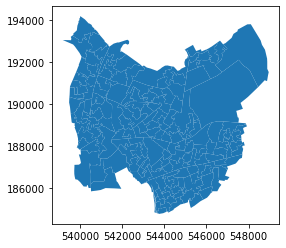

In [107]:
redbridge.plot()

In [108]:
type(redbridge)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

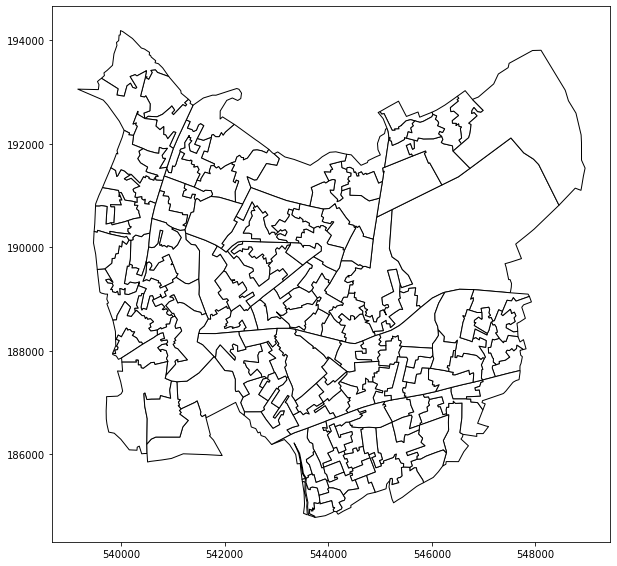

In [109]:
fig, ax = plt.subplots(figsize=(10,10))
redbridge.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})

In [110]:
redbridge.crs

<Projected CRS: PROJCS["OSGB 1936 / British National Grid",GEOGCS[ ...>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

<AxesSubplot:>

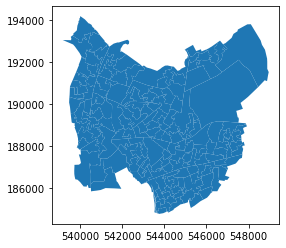

In [111]:
# Transfrorm the CRS to EPSG 22770
redbridge = redbridge.to_crs("EPSG:27700")
redbridge.plot()

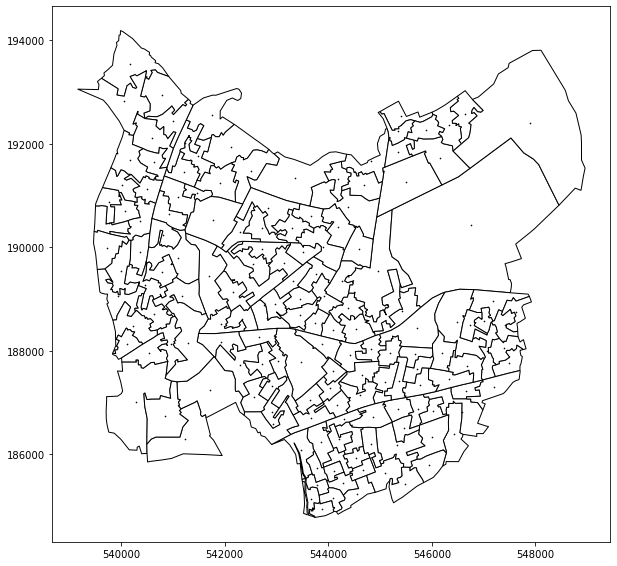

In [112]:
fig, ax = plt.subplots(figsize=(10,10))
redbridge.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})

# Plot centroids for each county
redbridge.centroid.plot(ax=ax, c='black', markersize=0.4)
plt.show()

In [113]:
redbridgeKNN5 = weights.distance.KNN.from_dataframe(redbridge, k=5, ids=redbridge['LSOA11NM'].tolist())

In [114]:
redbridgeKNN5mat = pd.DataFrame(*redbridgeKNN5.full()).astype(int)
redbridgeKNN5mat.columns = list(redbridgeKNN5mat.index)
redbridgeKNN5mat

,Redbridge 017A,Redbridge 013A,Redbridge 013B,Redbridge 013C,Redbridge 013D,Redbridge 017B,Redbridge 017C,Redbridge 017D,Redbridge 012A,Redbridge 015A,...,Redbridge 027C,Redbridge 027D,Redbridge 018B,Redbridge 018C,Redbridge 018D,Redbridge 034G,Redbridge 030H,Redbridge 019H,Redbridge 030I,Redbridge 019I
Redbridge 017A,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Redbridge 013A,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Redbridge 013B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Redbridge 013C,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Redbridge 013D,0,1,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Redbridge 034G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Redbridge 030H,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Redbridge 019H,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Redbridge 030I,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


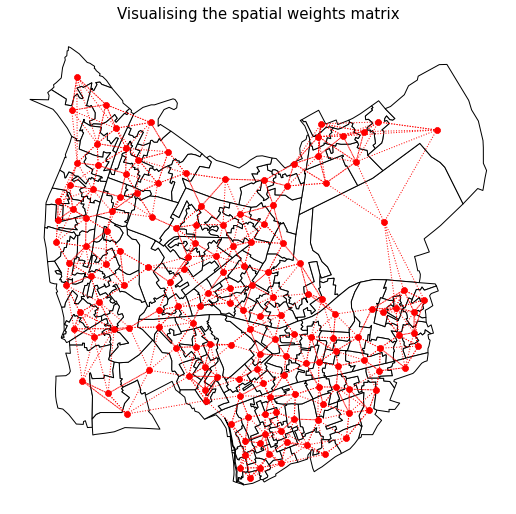

In [115]:
f, ax = plt.subplots(1, figsize=(9, 9))
redbridge.plot(ax=ax, edgecolor='k', facecolor='w')
redbridgeKNN5.plot(redbridge, indexed_on='LSOA11NM', ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(color='r', marker='8'))
ax.axis("off")
ax.set_title("Visualising the spatial weights matrix", fontsize=15)
#f.savefig('KNN_map.png', dpi=300, bbox_inches='tight', facecolor='white') 
plt.show()

moran's i

In [239]:
from pysal.explore import esda

mi = esda.moran.Moran(full_data['avg'], redbridgeKNN5, two_tailed=False)
print("The Statistic Moran's I is: "+str("%.4f"%mi.I),
      "\nThe Expected Value for Statistic I is: "+str("%.4f"%mi.EI),
      "\nThe Significance Test Value is: "+str("%.4f"%mi.p_norm))

The Statistic Moran's I is: 0.0437 
The Expected Value for Statistic I is: -0.0063 
The Significance Test Value is: 0.1421


In [240]:
mi.p_sim

0.144

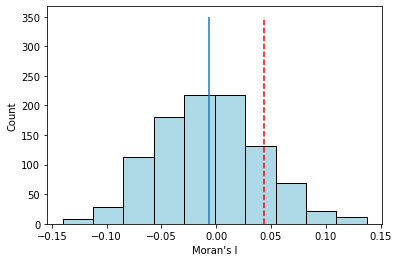

In [132]:
plt.hist(mi.sim, 10, facecolor='lightblue', edgecolor='black')
plt.vlines(mi.I, 0, 350, color='r', linestyle="--")
plt.vlines(mi.EI, 0, 350)
plt.xlabel("Moran's I")
plt.ylabel("Count")
plt.savefig('Moranhist.png', dpi=300, bbox_inches='tight', facecolor='white') 
plt.show()

Text(0.5, 0, "Moran's I")

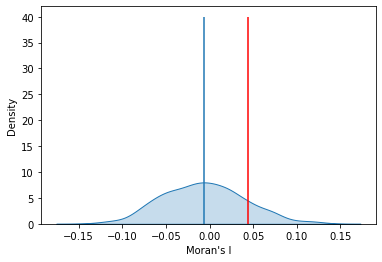

In [121]:
sns.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 40, color='r')
plt.vlines(mi.EI, 0, 40)
plt.xlabel("Moran's I")

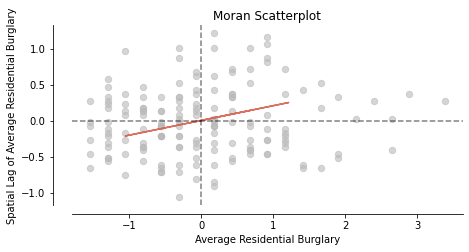

In [117]:
from splot.esda import moran_scatterplot
fig, ax = moran_scatterplot(mi, aspect_equal=True)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Average Residential Burglary')
plt.xlabel('Average Residential Burglary')
plt.show()

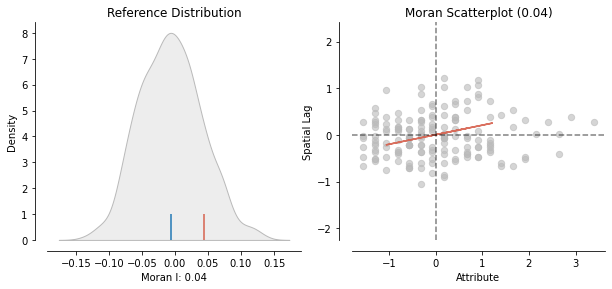

In [118]:
from splot.esda import plot_moran

plot_moran(mi, zstandard=True, figsize=(10,4))
plt.show()

In [233]:
#spatial lag
full_data['avg_lag'] = ps.weights.lag_spatial(redbridgeKNN5, full_data['avg'])

In [235]:
#standardise
full_data['avg_std'] = (full_data['avg'] - full_data['avg'].mean()) / full_data['avg'].std()
full_data['w_avg_std'] = ps.weights.lag_spatial(redbridgeKNN5, full_data['avg_std'])

In [236]:
full_data[['LSOA11NM', 'avg', 'w_avg', 'avg_std', 'w_avg_std']]

,LSOA11NM,avg,w_avg,avg_std,w_avg_std
0,Redbridge 017A,0.833333,0.916667,0.423684,0.669940
1,Redbridge 013A,0.583333,0.866667,-0.315086,0.522186
2,Redbridge 013B,0.583333,0.750000,-0.315086,0.177427
3,Redbridge 013C,0.416667,0.650000,-0.807599,-0.118081
4,Redbridge 013D,0.666667,0.816667,-0.068829,0.374432
...,...,...,...,...,...
156,Redbridge 034G,0.583333,0.616667,-0.315086,-0.216583
157,Redbridge 030H,0.750000,0.633333,0.177427,-0.167332
158,Redbridge 019H,0.166667,0.666667,-1.546369,-0.068829
159,Redbridge 030I,1.000000,0.600000,0.916197,-0.265835


In [237]:
full_data['avg'].median()

0.666666667

In [238]:
binary = full_data['avg']> full_data['avg'].median()
sum(binary)

71

Among 161 lsoas, less than half of them with average residential buglaries above the median (0.7) and remaining below the median.

In [123]:
# Building the Geographically Weighted Regression Model
model = mgwr.gwr.GWR(g_coords, # a collection of n sets of x and y coordinates
                     g_y, # dependent variable
                     g_X, # independent variables
                     bw.bw[0]) # bandwidth value  ( we use N nearest neighbours)

In [124]:
# Fit the model with particular estimations 
results = model.fit()
results.summary()

Model type                                                         Gaussian
Number of observations:                                                 161
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            145.817
Log-likelihood:                                                    -220.476
AIC:                                                                450.951
AICc:                                                               453.496
BIC:                                                               -646.882
R2:                                                                   0.094
Adj. R2:                                                              0.071

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

visualising GWR results

In [125]:
# We can check the shape of our local parameters array
print(results.params.shape)

(161, 5)


In [126]:
type(results.params)

numpy.ndarray

In [127]:
# Filtering only significant result at 0.05 (95% confidence interval)
filtered_estimates = results.filter_tvals(alpha=.05)
filtered_estimates

# Can you check the estimates using 99% and 90% confidence interval
filtered_estimates90 = results.filter_tvals(alpha=.1)
filtered_estimates99 = results.filter_tvals(alpha=.01)

In [128]:
# Convert arrays to data frame
data_params = pd.DataFrame(filtered_estimates)
data_localR2 = pd.DataFrame(results.localR2)

In [129]:
# Create the new dataframe
df1=pd.DataFrame(full_data["LSOA11NM"])
df2 = df1.assign(intercept=data_params[0],
                 logEmployment1=data_params[1],
                 sqrtEducation=data_params[2],
                 logAVHHOLDSZ_y=data_params[3],
                 POPDEN_y=data_params[4],
                localR2=data_localR2[0])
df2.columns
df2

,LSOA11NM,intercept,logEmployment1,sqrtEducation,logAVHHOLDSZ_y,POPDEN_y,localR2
0,Redbridge 017A,0.0,0.0,0.0,0.0,0.0,0.101395
1,Redbridge 013A,0.0,0.0,0.0,0.0,0.0,0.099405
2,Redbridge 013B,0.0,0.0,0.0,0.0,0.0,0.094197
3,Redbridge 013C,0.0,0.0,0.0,0.0,0.0,0.097811
4,Redbridge 013D,0.0,0.0,0.0,0.0,0.0,0.098812
...,...,...,...,...,...,...,...
156,Redbridge 034G,0.0,0.0,0.0,0.0,0.0,0.093287
157,Redbridge 030H,0.0,0.0,0.0,0.0,0.0,0.101333
158,Redbridge 019H,0.0,0.0,0.0,0.0,0.0,0.093679
159,Redbridge 030I,0.0,0.0,0.0,0.0,0.0,0.099745


(too many non-significant values?)

In [130]:
# Merge our shapefile with the model's results
full_data = full_data.merge(df2, left_on= 'LSOA11NM', right_on='LSOA11NM')
full_data.head()

,LSOA Code,LSOA11NM,avg,logavg,sqrtavg,index,LSOA11CD_x,MSOA11CD,MSOA11NM,LAD11CD_x,...,logHP,Centre,X,Y,intercept,logEmployment1_y,sqrtEducation_y,logAVHHOLDSZ_y_y,POPDEN_y_y,localR2
0,E01003638,Redbridge 017A,0.833333,-0.182322,0.912871,3556,E01003638,E02000767,Redbridge 017,E09000026,...,12.989474,POINT (544266.227 189352.563),544266.227330,544266.227330,0.0,0.0,0.0,0.0,0.0,0.101395
1,E01003639,Redbridge 013A,0.583333,-0.538997,0.763763,3557,E01003639,E02000763,Redbridge 013,E09000026,...,12.714536,POINT (544955.822 189532.909),544955.822118,544955.822118,0.0,0.0,0.0,0.0,0.0,0.099405
2,E01003640,Redbridge 013B,0.583333,-0.538997,0.763763,3558,E01003640,E02000763,Redbridge 013,E09000026,...,12.782388,POINT (546760.906 190418.788),546760.906080,546760.906080,0.0,0.0,0.0,0.0,0.0,0.094197
3,E01003641,Redbridge 013C,0.416667,-0.875469,0.645497,3559,E01003641,E02000763,Redbridge 013,E09000026,...,12.920291,POINT (545427.089 188769.203),545427.089277,545427.089277,0.0,0.0,0.0,0.0,0.0,0.097811
4,E01003642,Redbridge 013D,0.666667,-0.405465,0.816497,3560,E01003642,E02000763,Redbridge 013,E09000026,...,12.657925,POINT (545128.323 188885.740),545128.323466,545128.323466,0.0,0.0,0.0,0.0,0.0,0.098812


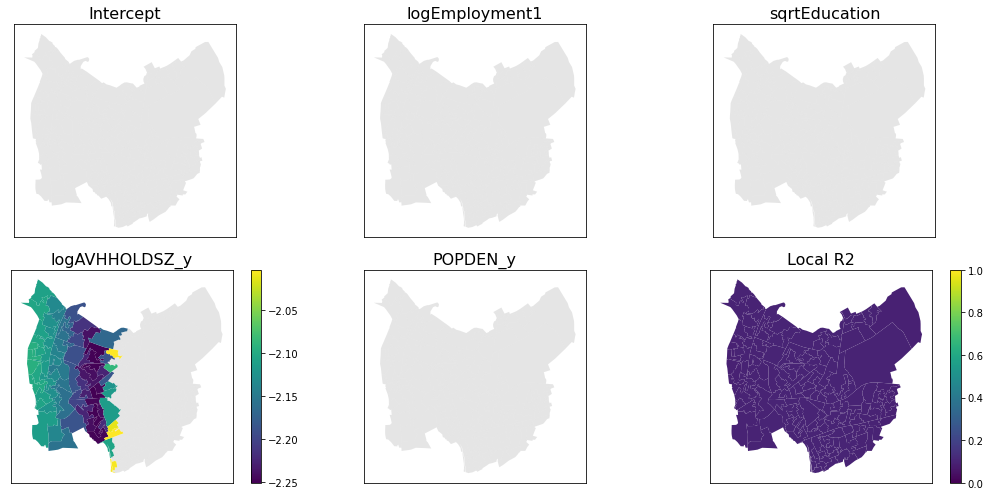

In [131]:
# First, let's create empty set of subplots with 2 rows and 3 columns
f,ax=plt.subplots(2,3,figsize=(15,7), subplot_kw=dict(aspect='equal'))
# Flatten them
ax = ax.flatten()
# Define the title of our plots
titles = ['Intercept','logEmployment1','sqrtEducation','logAVHHOLDSZ_y','POPDEN_y']

# Here, we are creating loop for our parameter estimates 
for i,row in enumerate(filtered_estimates.T):
    # We want to plot all the non-significant estimates in grey
    full_data = full_data.assign(toplot=filtered_estimates.T[i])
    (full_data.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))
    # and assign colours only to the significant estimates
    (full_data.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='viridis',
           ax=ax[i],
           legend=True))
    
    ax[i].set_title(titles[i], fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

    # For the last one, local R2, we can just map all of them regarding the significance

(full_data.assign(r2=results.localR2)
 .sort_values('r2')
 .plot('r2',
       ax=ax[-1],
       legend=True,
       vmin=0,
       vmax=1,
       cmap='viridis'))
    
ax[-1].set_xticklabels([])
ax[-1].set_yticklabels([])
ax[-1].set_xticks([])
ax[-1].set_yticks([])
    
ax[-1].set_title('Local R2', fontsize=16)
    
f.tight_layout()
    
plt.show()